1. Load dataset
2. Get attention mask, masked image embedding (for LM decoding), and concept attribution
3. Decode masked image embedding with LM

In [121]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

from dataset import LitAwA2DM, AwA2Dataset
from blip_cbm import LitBlipConceptCLS as LitModel
from utils import get_named_module

In [118]:
import torch
from captum._utils.gradient import compute_layer_gradients_and_eval

from transformers.image_utils import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD
from transformers import BlipForConditionalGeneration, BlipProcessor

In [3]:
class BlipForConditionalGenerationConceptCLS(BlipForConditionalGeneration):
    # https://github.com/huggingface/transformers/blob/7bce8042606b01d0dba3b83d5d606f47529d6ba4/src/transformers/models/blip/modeling_blip.py#L1034
    @torch.no_grad()
    def generate_cls(self, image_embeds, input_ids=None, attention_mask=None, **generate_kwargs,):
        batch_size = image_embeds.shape[0]
        image_attention_mask = torch.ones(image_embeds.shape[:-1], dtype=torch.long).to(image_embeds.device)

        if isinstance(input_ids, list):
            input_ids = torch.LongTensor(input_ids)
        elif input_ids is None:
            input_ids = (
                torch.LongTensor([[self.decoder_input_ids, self.config.text_config.eos_token_id]])
                .repeat(batch_size, 1)
                .to(image_embeds.device)
            )

        input_ids[:, 0] = self.config.text_config.bos_token_id
        attention_mask = attention_mask[:, :-1] if attention_mask is not None else None

        outputs = self.text_decoder.generate(
            input_ids=input_ids[:, :-1],
            eos_token_id=self.config.text_config.sep_token_id,
            pad_token_id=self.config.text_config.pad_token_id,
            attention_mask=attention_mask,
            encoder_hidden_states=image_embeds,
            encoder_attention_mask=image_attention_mask,
            **generate_kwargs,
        )

        return outputs

In [4]:
def processed_to_rgb(x):
    x = x['pixel_values'].detach().cpu().squeeze(0).numpy()
    x = np.transpose(x, (1, 2, 0))
    x = (x * OPENAI_CLIP_STD) + OPENAI_CLIP_MEAN
    x = (x * 255).astype(np.uint8)
    return x

In [201]:
def topk_idx_to_pixel_mask(topk_idx, n_patches=24, pixel_per_patch=16, verbose=False):
    # topk_idx,shape = [B, NC, k]
    B, NC = topk_idx.shape[0], topk_idx.shape[1]
    mask = np.zeros([B, NC, n_patches * pixel_per_patch, n_patches * pixel_per_patch])
    for i in range(B):
        for j in range(NC):
            for k in topk_idx[i, j]:
                x_shift = k // n_patches
                y_shift = k % n_patches
                mask[i, j, 
                     x_shift * pixel_per_patch:(x_shift + 1) * pixel_per_patch, 
                     y_shift * pixel_per_patch:(y_shift + 1) * pixel_per_patch] = 1
            if verbose:
                plt.imshow(mask[i, j])
                plt.axis('off')
                plt.show()
    return mask

In [282]:
def get_concept_attribution(model, x, y, layer_name='classification'):
    layer = get_named_module(model, layer_name)
    forward_func = lambda *args, **kwargs: model(*args, *kwargs).softmax(-1)
    layer_gradients, layer_evals = compute_layer_gradients_and_eval(
        forward_func, layer, x, y, attribute_to_layer_input=True,
    )
    with torch.no_grad():
        score = layer_gradients[0] @ model.concept_cls.weight.T
    return score

In [816]:
def calibrate_concept_cls(masked_q):
    concept_cls = masked_q[:, :, 0]
    image_embs = masked_q[:, :, 1:]
    mu_0 = concept_cls.mean(dim=(2)).unsqueeze(-1)
    std_0 = concept_cls.std(dim=(2)).unsqueeze(-1)
    mu_1 = image_embs.mean(dim=(2, 3)).unsqueeze(-1)
    std_1 = image_embs.std(dim=(2, 3)).unsqueeze(-1)
    concept_cls = ((concept_cls - mu_0) / std_0) * std_1 + mu_1
    return torch.cat([concept_cls.unsqueeze(2), image_embs], dim=2)

In [6]:
processor = processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
transform = lambda *args, **kwargs: processor.image_processor.preprocess(*args, return_tensors='pt', **kwargs)

In [7]:
decoder = BlipForConditionalGenerationConceptCLS.from_pretrained("Salesforce/blip-image-captioning-base")

In [8]:
dset = AwA2Dataset(root_dir='/home/andrewbai/data/', split='valid', transform=transform)

In [720]:
ckpt_path = './lightning_logs/AwA2_CBM/blip_prefix_v3_alpha0/checkpoints/last.ckpt'
model = LitModel.load_checkpoint_as_model(ckpt_path).eval()

/home/andrewbai/miniconda3/envs/hf/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:246: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss_c.pos_weight', 'loss_y.weight']
  rank_zero_warn(


In [721]:
model

BLIPConceptPrefixModelV3(
  (projector): BlipModel(
    (text_model): BlipTextModel(
      (embeddings): BlipTextEmbeddings(
        (word_embeddings): Embedding(30524, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): BlipTextEncoder(
        (layer): ModuleList(
          (0): BlipTextLayer(
            (attention): BlipTextAttention(
              (self): BlipTextSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): BlipTextSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (La

In [759]:
i = 2
print(dset.class_names[dset[i][2]])

antelope


In [837]:
output = model(dset[i][0], return_masked_q=True, return_topk_idx=True, return_dict=True, 
               topk=4, include_concept_cls=False)
# output['masked_q_calibrated'] = calibrate_concept_cls(output['masked_q'])

In [838]:
output_ids = decoder.generate_cls(output['masked_q'].squeeze(0)[:, 0].unsqueeze(1), max_new_tokens=5, repetition_penalty=1.1)

In [839]:
nls = [l.strip() for l in processor.batch_decode(output_ids, skip_special_tokens=True)]

In [840]:
for i_, nl in enumerate(nls):
    print(i_, nl)

0 deer deer deer deer deer
1 deer deer deer deer deer
2 a deer young ant deer
3 deer ant gaze deer deer
4 deer deer deer deer deer
5 deer deer deer deer deer
6 a deer deer deer deer
7 deer deer deer deer deer
8 an horns goat horns horns
9 horns ant horns horns horns
10 deer deer deer deer deer
11 deer deer deer deer deer
12 deer deer deer deer deer
13 a deer young deer deer
14 deer deer deer deer deer
15 deer deer deer deer deer
16 a white white white white
17 a a a a a
18 deer deer deer deer deer
19 a a a a a
20 an ram horns a an
21 a white white white white
22 deer ant gaze deer deer
23 a a a a a
24 deer deer deer deer deer
25 horns ant horns horns horns
26 a goat goat goat goat
27 deer deer deer deer deer
28 deer deer deer deer deer
29 deer deer deer deer deer
30 a a a a a
31 a white white white white
32 a deer deer deer deer
33 a a a a a
34 a deer young ant deer
35 deer deer deer deer deer
36 a a a a a
37 a a a a a
38 deer deer deer deer deer
39 deer deer deer deer deer
40 a deer y

In [841]:
mask = topk_idx_to_pixel_mask(output['topk_idx'])

In [842]:
score = get_concept_attribution(model, dset[i][0], dset[i][2])
print(score)

tensor([[ 3.0122e-05, -7.5318e-05,  1.0516e-04, -1.1651e-04, -1.1142e-05,
          6.9300e-05,  3.7647e-05,  7.0997e-05,  1.4041e-06, -1.6090e-05,
         -8.0570e-05,  3.3132e-05,  1.2832e-05, -1.1330e-04, -3.8211e-05,
         -3.3509e-05,  3.5395e-05,  4.2639e-05,  6.8700e-05, -9.5886e-05,
          3.5586e-05,  1.6254e-05,  6.5625e-05, -5.5595e-05,  3.5777e-05,
         -2.4600e-08,  8.8987e-05, -1.8191e-05,  9.9206e-05, -4.9092e-07,
         -5.0452e-05,  7.6542e-05, -6.3533e-05, -6.3693e-05,  2.3230e-05,
         -1.0191e-05, -7.7605e-05,  3.0020e-05, -5.2453e-05,  8.4345e-06,
         -6.4098e-06, -3.5220e-05, -6.7027e-05, -5.7739e-05,  3.4109e-05,
         -1.6163e-05, -3.9048e-05,  2.4680e-05,  8.0200e-05,  9.2139e-05,
         -1.5397e-05,  9.0941e-05, -6.8277e-05, -2.1014e-05,  1.7668e-08,
         -5.5548e-07,  6.5584e-06, -4.5073e-05,  6.3075e-05,  6.9562e-06,
          5.4386e-06,  2.4683e-05,  3.5117e-05, -4.2380e-06, -3.0997e-05,
         -5.0034e-05, -5.4027e-05, -7.

In [843]:
c = 16

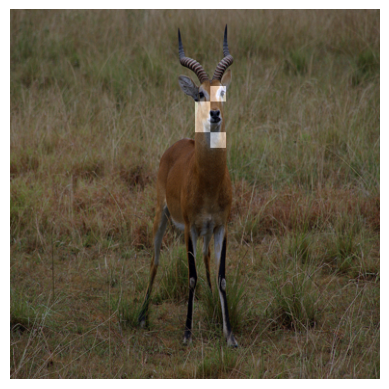

In [844]:
x = processed_to_rgb(dset[i][0])
plt.imshow(x)
plt.imshow(mask[0][c], alpha=0.4, cmap='gray')
plt.axis('off')
plt.show()

a white white white white


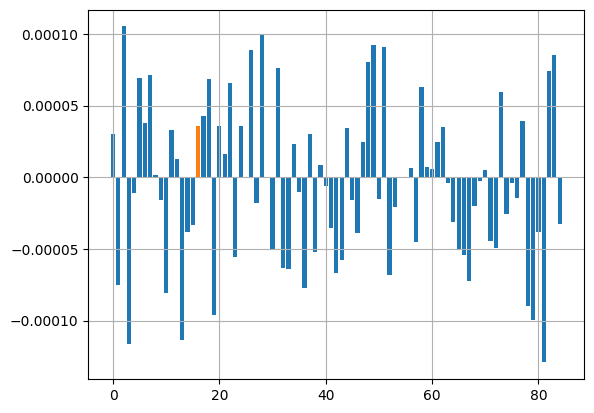

In [845]:
print(nls[c]) # , score[0][c].item())
plt.bar(np.arange(len(score[0])), score[0], 
        color=['tab:orange' if i == c else 'tab:blue' for i in range(len(score[0]))])
plt.grid()
plt.show()

In [786]:
output['masked_q'].squeeze(0).shape

torch.Size([85, 2, 768])

In [789]:
output['masked_q'].squeeze(0)[0, 0, :10].detach().cpu().numpy()

array([-0.6680532 ,  0.38796467, -0.24902381,  1.4282119 ,  1.0936763 ,
        1.0271289 , -0.3554036 , -1.2322087 ,  0.80533624,  0.28988057],
      dtype=float32)